# Trial Summary 

Data preparation:
- Filter genes with less than 10 non-zero expressions spots

Model:
- Nueral Matrix Factorization

Results:
- Train RMSE: 3.36
- Valid RMSE: 3.70
- Test RMSE: 3.70

# Imports

In [11]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import pickle
import torch.optim as optim
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader
import trainer_nmf as trainer
import data_nmf as get_data
from data_nmf import get_expressions
from models import get_model
import tester_nmf as tester
from loss import *
from results_analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Load Data 

In [13]:
min_counts = 500
min_cells = 177
apply_log = False
batch_size = 128

In [14]:
dl_train, dl_valid, dl_test, _ = get_data.main(
    min_counts=min_counts,
    min_cells=min_cells,
    apply_log=apply_log, 
    batch_size=batch_size, 
    device=device
)

Finish loading the data


# Modelling

## Set HyperParameters

In [17]:
model_name = 'NMF'
max_epochs = 1
early_stopping = 10
model_params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': batch_size
}

## Build Model 

In [18]:
model = get_model(model_name, model_params, dl_train)
optimizer = getattr(optim, model_params['optimizer'])(model.parameters(), lr=model_params['learning_rate'])
criterion = RMSELoss()

## Train Model 

In [19]:
model, valid_loss = trainer.train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    max_epochs=max_epochs,
    early_stopping=early_stopping,
    dl_train=dl_train,
    dl_test=dl_valid, 
    device=device
)

Training Results - Epoch[1] Avg loss: 7.51
Validation Results - Epoch[1] Avg loss: 13.90


## Test 

In [20]:
test_loss, df_test_preds = tester.test(
    model=model,
    criterion=criterion,
    dl_test=dl_test,
    device=device
)
print(f'Test loss = {test_loss}')

Test loss = 13.897642969652564


# Results Analysis 

In [21]:
df_test_preds['y_fixed'] = np.exp(df_test_preds['y'])
df_test_preds['y_pred_fixed'] = np.exp(df_test_preds['y_pred'])

y_col = 'y'
y_pred_col = 'y_pred'

df_test_preds['error'] = df_test_preds[y_col] - df_test_preds[y_pred_col]
df_test_preds.head()

,gene,spot,y,y_pred,y_fixed,y_pred_fixed,error
0,4831,837,2.0,1.901270,7.389056,6.694394,0.098730
1,5258,888,2.0,-3.761112,7.389056,0.023258,5.761112
2,5907,630,3.0,4.030430,20.085537,56.285100,-1.030430
3,3508,100,4.0,1.670948,54.598150,5.317204,2.329052
4,3204,231,6.0,-4.295665,403.428793,0.013628,10.295665


## Errors Distribution 

count    426393.000000
mean          1.184312
std           5.949039
min         -97.634033
25%           0.070497
50%           0.711687
75%           1.604807
max         710.058319
Name: error, dtype: float64


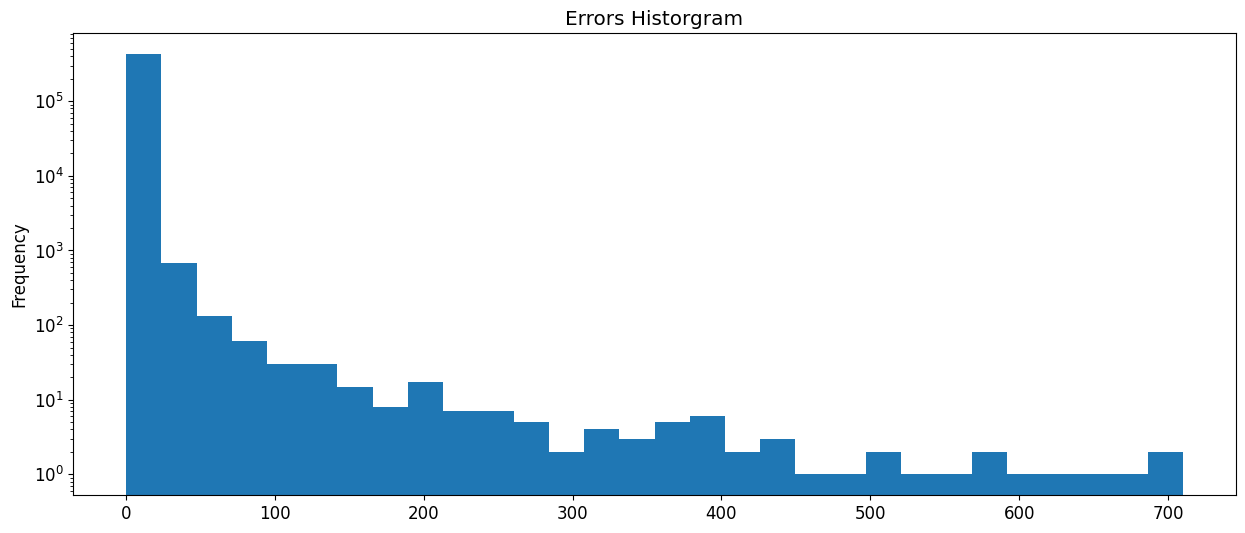

In [12]:
error_distribution(df_test_preds)

## Spots Errors Distribution 

In [14]:
spots_error_distribution(df_test_preds)

count    1185.000000
mean        1.162715
std         0.492027
min         0.188720
25%         0.897909
50%         1.080048
75%         1.318893
max         5.662536
Name: error, dtype: float64


## Genes Errors Distribution 

In [15]:
genes_error_distribution(df_test_preds)

count    6279.000000
mean        1.046319
std         2.261767
min        -0.427010
25%         0.727440
50%         0.863820
75%         1.024416
max       137.366875
Name: error, dtype: float64


## Errors Heat Map 

(1185, 6279)


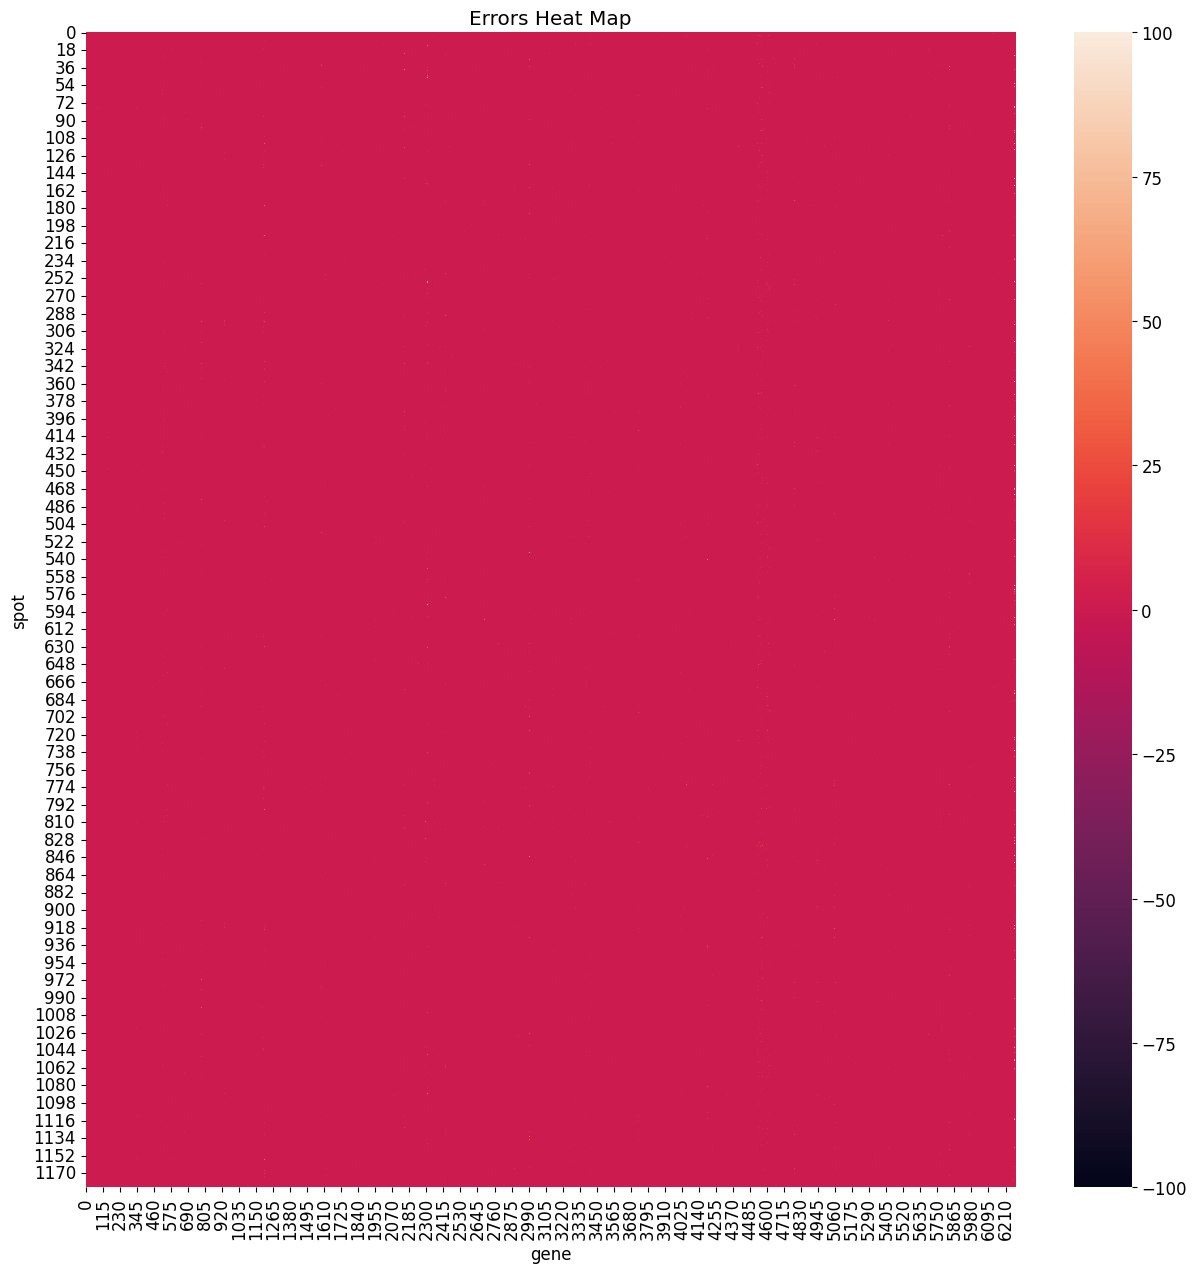

In [18]:
error_heat_map(df_test_preds, vmin=-100, vmax=100)

# PCA + KMeans Clustering 

In [22]:
_, obj, _, _ = get_expressions(min_counts=min_counts, min_cells=min_cells, apply_log=apply_log)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285
New shape after filtering: (1185, 6279)
Data shape: (7440615, 3)
Number of genes: 6279
Number of spots: 1185


In [42]:
# Load Ordinal Encoders
with open(path.join('/', 'data', 'NMF', 'genes_encoder.pkl'), 'rb') as f:
    oe_genes = pickle.load(f)
with open(path.join('/', 'data', 'NMF', 'spots_encoder.pkl'), 'rb') as f:
    oe_spots = pickle.load(f)

dl_train_nmf = torch.load(path.join('/', 'data', 'NMF', 'dl_train.pth'))
nmf_train_genes, nmf_train_spots, nmf_train_expressions = dl_train_nmf.dataset.get_all_data()
df_nmf_train_tmp = pd.DataFrame({'gene': nmf_train_genes.to('cpu'), 'spot': nmf_train_spots.to('cpu'), 'expression': nmf_train_expressions.to('cpu')})
df_nmf_train_tmp[['gene']] = oe_genes.inverse_transform(df_nmf_train_tmp[['gene']].values)
df_nmf_train_tmp[['spot']] = oe_spots.inverse_transform(df_nmf_train_tmp[['spot']].values)
df_nmf_train_matrix_tmp = df_nmf_train_tmp.pivot(index='spot', columns='gene', values='expression')

In [43]:
df_nmf_train = df_test_preds[['gene', 'spot', y_pred_col]].rename(columns={y_pred_col: 'expression'})
df_nmf_train[['gene']] = oe_genes.inverse_transform(df_nmf_train[['gene']].values)
df_nmf_train[['spot']] = oe_spots.inverse_transform(df_nmf_train[['spot']].values)
df_nmf_train_matrix = df_nmf_train.pivot(index='spot', columns='gene', values='expression')
df_nmf_train_matrix.fillna(df_nmf_train_matrix_tmp, inplace=True)
df_nmf_train_matrix.clip(lower=0, inplace=True)
display(df_nmf_train_matrix.head())
tmp_genes_locations = [obj.var.index.get_loc(key=gene_key) for gene_key in df_nmf_train_matrix.columns]
# Replace the values
obj.X[:, tmp_genes_locations] = df_nmf_train_matrix.values

gene,0610009B22Rik,0610009L18Rik,0610010K14Rik,0610012G03Rik,1110004F10Rik,1110008P14Rik,1110032A03Rik,1110038B12Rik,1110038F14Rik,1110051M20Rik,...,mt-Co1,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5
spot,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,...,62.0,28.000000,0.0,28.0,9.00000,0.575049,4.0,22.0,0.000000,0.0
AAACCGGGTAGGTACC-1,1.0,0.000000,0.000000,2.502065,3.0,5.773089,7.000000,0.755364,0.0,1.573512,...,1587.0,962.000000,1292.0,571.0,398.00000,318.000000,58.0,0.0,2.443757,31.0
AAACCGTTCGTCCAGG-1,0.0,1.523338,0.000000,6.000000,7.0,4.653192,3.265023,1.000000,0.0,8.000000,...,832.0,0.000000,761.0,339.0,0.00000,171.000000,42.0,278.0,3.000000,0.0
AAACGAGACGGTTGAT-1,1.0,0.000000,0.239136,0.000000,0.0,3.000000,1.000000,0.000000,3.0,4.000000,...,575.0,0.000000,562.0,0.0,178.00000,119.000000,25.0,175.0,3.000000,0.0
AAACTGCTGGCTCCAA-1,1.0,4.983594,2.000000,4.000000,0.0,0.000000,0.000000,0.000000,1.0,4.016880,...,0.0,0.694106,691.0,306.0,4.07372,0.000000,34.0,0.0,1.000000,27.0


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


<Figure size 640x480 with 0 Axes>

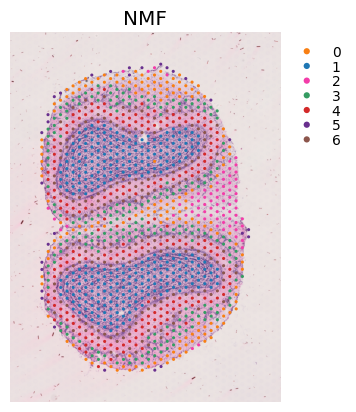

In [44]:
pca_kmeans_clustering(
    data_obj=obj, 
    title='NMF'
)